In [1]:
!pip install langchain langchain-community pypdf2 python-dotenv openai tiktoken


  Using cached pypdf2-3.0.1-py3-none-any.whl.metadata (6.8 kB)
   ---------------------------------------- 0.0/2.5 MB ? eta -:--:--
   ---------------- ----------------------- 1.0/2.5 MB 6.3 MB/s eta 0:00:01
   --------------------------------- ------ 2.1/2.5 MB 5.9 MB/s eta 0:00:01
   ---------------------------------------- 2.5/2.5 MB 5.2 MB/s  0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 4.5 MB/s  0:00:00
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   -------------- ------------------------- 0.8/2.1 MB 4.8 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB 5.3 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 5.2 MB/s  0:00:00
Using cached pypdf2-3.0.1-py3-none-any.whl (232 kB)
   ---------------------------------------- 0.0/879.4 kB ? eta -:--:--
   ---------------------------------------- 879.4/879.4 kB 5.7 MB/s  0:00:00

   ---

In [2]:
# Load API key from Windows environment variables
import os

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

if not OPENAI_API_KEY:
    raise ValueError("OPENAI_API_KEY not found in Windows environment variables")

print("OPENAI_API_KEY loaded successfully from system environment.")


OPENAI_API_KEY loaded successfully from system environment.


In [3]:
from openai import OpenAI
import os

# Initialize client (API key автоматически берётся из Windows environment variables)
client = OpenAI()

audio_path = r"C:\Users\kupit\week 2\w2d5\The_Blueprint_For_Trustworthy_AI.m4a"
output_path = r"C:\Users\kupit\week 2\w2d5\podcast_transcript.txt"

# Transcribe audio
with open(audio_path, "rb") as audio_file:
    transcription = client.audio.transcriptions.create(
        model="gpt-4o-transcribe",
        file=audio_file
    )

podcast_text = transcription.text

# Save transcription to local file
with open(output_path, "w", encoding="utf-8") as f:
    f.write(podcast_text)

print("Transcription completed and saved successfully.")
print(f"Transcript length: {len(podcast_text)} characters")
print("\nPreview:\n")
print(podcast_text[:500])


Transcription completed and saved successfully.
Transcript length: 9931 characters

Preview:

So imagine for a second you're driving across, I don't know, a massive suspension bridge. Okay. You don't pull over halfway across, get out, and demand to see the blueprints, right? You don't interview the welding crew. No, you just, you trust it. You just drive. You trust the bridge. You trust the engineering standards, the inspections, the laws that say this thing won't fail. Right. It's trust in the infrastructure. It's invisible, but it's there. Exactly. But now let's switch gears. Think abo


In [1]:
import PyPDF2

pdf_path = r"C:\Users\kupit\week 2\w2d5\ethics_guidelines_for_trustworthy_ai-fr_87FE7A3C-D03D-9305-81A653DDA84B5A60_60427.pdf"

pdf_text = ""

with open(pdf_path, "rb") as pdf_file:
    reader = PyPDF2.PdfReader(pdf_file)
    
    for page in reader.pages:
        pdf_text += page.extract_text() + "\n"

print("PDF loaded successfully.")
print(pdf_text[:500])  # preview first 500 characters


PDF loaded successfully.
 
 
GROUPE D ’EXPERTS  
INDEPENDANTS DE HAUT  NIVEAU SUR  
L’INTELLIGENCE ARTIFIC IELLE 
CONSTITUE PAR LA COMMISSION EUROPEENNE EN JUIN  2018  
 
 
 
 
 
 
 
LIGNES DIRECTRICES EN  
MATIERE D ’ETHIQUE  
POUR UNE IA DIGNE DE 
CONFIANCE  
 
 
 
 
  
 
LIGNES DIRECTRICES  EN MATIERE D ’ETHIQUE pour UNE IA DIGNE 
DE CONFIANCE  
 
Groupe d’experts de haut niveau sur l’intelligence artificielle  
 
 
 
 
 
 
 
 
Le présent document a été rédigé par le groupe d’experts de haut niveau sur l’intelligence


In [4]:
print(f"Podcast transcript length: {len(podcast_text)} characters")
print(f"PDF text length: {len(pdf_text)} characters")


Podcast transcript length: 9931 characters
PDF text length: 195189 characters


In [13]:
import os
import re
import numpy as np
from langchain_text_splitters import CharacterTextSplitter

# -----------------------------
# 1️⃣ Fixed-size chunking function
# -----------------------------

def fixed_chunking(text, chunk_size, overlap):
    """
    Chunk text into fixed-size pieces.
    separator="" ensures splitting even if text is one long block.
    """
    splitter = CharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
        separator=""   # important for long single-block text (like podcast)
    )
    return splitter.split_text(text)


In [14]:
# -----------------------------
# 2️⃣ Configurations and chunking
# -----------------------------

fixed_configs = [
    (500, 0),
    (1000, 50),
    (2000, 100)
]

results_fixed = {}

for size, overlap in fixed_configs:
    # PDF
    results_fixed[f"pdf_{size}_{overlap}"] = fixed_chunking(pdf_text, size, overlap)
    # Podcast
    results_fixed[f"podcast_{size}_{overlap}"] = fixed_chunking(podcast_text, size, overlap)

print("Fixed-size chunking for PDF and Podcast complete.")


Fixed-size chunking for PDF and Podcast complete.


In [15]:
# -----------------------------
# 3️⃣ Boundary analysis functions
# -----------------------------

def sentence_break_ratio(chunks):
    breaks = 0
    for chunk in chunks[:-1]:
        if not re.search(r"[.!?]\s*$", chunk.strip()):
            breaks += 1
    return breaks / len(chunks)

def paragraph_break_ratio(chunks):
    breaks = 0
    for chunk in chunks[:-1]:
        if not chunk.strip().endswith("\n"):
            breaks += 1
    return breaks / len(chunks)

def analyze_chunks(name, chunks):
    lengths = [len(c) for c in chunks]
    return {
        "num_chunks": len(chunks),
        "avg_length": int(np.mean(lengths)),
        "min_length": min(lengths),
        "max_length": max(lengths),
        "sentence_break_ratio": round(sentence_break_ratio(chunks), 2),
        "paragraph_break_ratio": round(paragraph_break_ratio(chunks), 2)
    }


In [16]:
# -----------------------------
# 4️⃣ Run analysis for all configs
# -----------------------------

analysis_fixed = {}

for key, chunks in results_fixed.items():
    analysis_fixed[key] = analyze_chunks(key, chunks)

# Print results
for key, stats in analysis_fixed.items():
    print(f"\n===== {key} =====")
    for k, v in stats.items():
        print(f"{k}: {v}")



===== pdf_500_0 =====
num_chunks: 391
avg_length: 497
min_length: 183
max_length: 500
sentence_break_ratio: 0.98
paragraph_break_ratio: 1.0

===== podcast_500_0 =====
num_chunks: 20
avg_length: 496
min_length: 431
max_length: 500
sentence_break_ratio: 0.95
paragraph_break_ratio: 0.95

===== pdf_1000_50 =====
num_chunks: 206
avg_length: 996
min_length: 434
max_length: 1000
sentence_break_ratio: 0.99
paragraph_break_ratio: 1.0

===== podcast_1000_50 =====
num_chunks: 11
avg_length: 948
min_length: 431
max_length: 1000
sentence_break_ratio: 0.91
paragraph_break_ratio: 0.91

===== pdf_2000_100 =====
num_chunks: 103
avg_length: 1992
min_length: 1383
max_length: 2000
sentence_break_ratio: 0.96
paragraph_break_ratio: 0.99

===== podcast_2000_100 =====
num_chunks: 6
avg_length: 1738
min_length: 431
max_length: 2000
sentence_break_ratio: 0.83
paragraph_break_ratio: 0.83


In [17]:
# -----------------------------
# 5️⃣ Compare PDF vs Podcast
# -----------------------------

print("\n=== CONTENT TYPE COMPARISON (FIXED CHUNKING) ===")

for size, overlap in fixed_configs:
    pdf_key = f"pdf_{size}_{overlap}"
    podcast_key = f"podcast_{size}_{overlap}"
    
    pdf_score = analysis_fixed[pdf_key]["sentence_break_ratio"]
    podcast_score = analysis_fixed[podcast_key]["sentence_break_ratio"]
    
    better = "PDF" if pdf_score < podcast_score else "Podcast"
    
    print(f"\nChunk size {size}, overlap {overlap}:")
    print(f"PDF sentence break ratio: {pdf_score}")
    print(f"Podcast sentence break ratio: {podcast_score}")
    print(f"Better handled content: {better}")



=== CONTENT TYPE COMPARISON (FIXED CHUNKING) ===

Chunk size 500, overlap 0:
PDF sentence break ratio: 0.98
Podcast sentence break ratio: 0.95
Better handled content: Podcast

Chunk size 1000, overlap 50:
PDF sentence break ratio: 0.99
Podcast sentence break ratio: 0.91
Better handled content: Podcast

Chunk size 2000, overlap 100:
PDF sentence break ratio: 0.96
Podcast sentence break ratio: 0.83
Better handled content: Podcast


In [2]:
!pip install langchain-text-splitters


In [18]:
# -----------------------------
# 6️⃣ Export chunks to files
# -----------------------------

# PDF
os.makedirs("chunks/fixed/pdf", exist_ok=True)
for key, chunks in results_fixed.items():
    if key.startswith("pdf"):
        file_path = f"chunks/fixed/pdf/{key}.txt"
        with open(file_path, "w", encoding="utf-8") as f:
            for i, chunk in enumerate(chunks):
                f.write(f"\n--- CHUNK {i+1} ---\n")
                f.write(chunk)
                f.write("\n")

# Podcast
os.makedirs("chunks/fixed/podcast", exist_ok=True)
for key, chunks in results_fixed.items():
    if key.startswith("podcast"):
        file_path = f"chunks/fixed/podcast/{key}.txt"
        with open(file_path, "w", encoding="utf-8") as f:
            for i, chunk in enumerate(chunks):
                f.write(f"\n--- CHUNK {i+1} ---\n")
                f.write(chunk)
                f.write("\n")

print("All fixed-size chunks exported to chunks/fixed/")


All fixed-size chunks exported to chunks/fixed/


In [20]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# -----------------------------
# 1️⃣ Recursive chunking function
# -----------------------------
def recursive_chunking(text, chunk_size, overlap):
    """
    Chunk text recursively trying to preserve semantic boundaries:
    - paragraphs (\n\n)
    - lines (\n)
    - sentences (. )
    - words (" ")
    - fallback: single characters
    """
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
        length_function=len,
        separators=["\n\n", "\n", ". ", " ", ""]
    )
    return splitter.split_text(text)


In [21]:
# -----------------------------
# 2️⃣ Configurations
# -----------------------------
recursive_configs = [
    (500, 50),
    (1000, 200),
    (2000, 200)
]

results_recursive = {}

# Chunk both PDF and Podcast
for size, overlap in recursive_configs:
    # PDF
    key_pdf = f"pdf_{size}_{overlap}"
    results_recursive[key_pdf] = recursive_chunking(pdf_text, size, overlap)
    # Podcast
    key_podcast = f"podcast_{size}_{overlap}"
    results_recursive[key_podcast] = recursive_chunking(podcast_text, size, overlap)

print("Recursive chunking for PDF and Podcast complete.")


Recursive chunking for PDF and Podcast complete.


In [22]:
# -----------------------------
# 3️⃣ Boundary analysis functions (same as STEP 2)
# -----------------------------
def sentence_break_ratio(chunks):
    breaks = 0
    for chunk in chunks[:-1]:
        if not re.search(r"[.!?]\s*$", chunk.strip()):
            breaks += 1
    return breaks / len(chunks)

def paragraph_break_ratio(chunks):
    breaks = 0
    for chunk in chunks[:-1]:
        if not chunk.strip().endswith("\n"):
            breaks += 1
    return breaks / len(chunks)

def analyze_chunks(name, chunks):
    lengths = [len(c) for c in chunks]
    return {
        "num_chunks": len(chunks),
        "avg_length": int(np.mean(lengths)),
        "min_length": min(lengths),
        "max_length": max(lengths),
        "sentence_break_ratio": round(sentence_break_ratio(chunks), 2),
        "paragraph_break_ratio": round(paragraph_break_ratio(chunks), 2)
    }


In [23]:
# -----------------------------
# 4️⃣ Run analysis for all recursive configs
# -----------------------------
analysis_recursive = {}

for key, chunks in results_recursive.items():
    analysis_recursive[key] = analyze_chunks(key, chunks)

# Print results
for key, stats in analysis_recursive.items():
    print(f"\n===== {key} =====")
    for k, v in stats.items():
        print(f"{k}: {v}")



===== pdf_500_50 =====
num_chunks: 445
avg_length: 438
min_length: 89
max_length: 498
sentence_break_ratio: 0.78
paragraph_break_ratio: 1.0

===== podcast_500_50 =====
num_chunks: 23
avg_length: 450
min_length: 100
max_length: 499
sentence_break_ratio: 0.96
paragraph_break_ratio: 0.96

===== pdf_1000_200 =====
num_chunks: 240
avg_length: 934
min_length: 89
max_length: 998
sentence_break_ratio: 0.83
paragraph_break_ratio: 1.0

===== podcast_1000_200 =====
num_chunks: 13
avg_length: 916
min_length: 416
max_length: 999
sentence_break_ratio: 0.92
paragraph_break_ratio: 0.92

===== pdf_2000_200 =====
num_chunks: 110
avg_length: 1897
min_length: 89
max_length: 1998
sentence_break_ratio: 0.77
paragraph_break_ratio: 0.99

===== podcast_2000_200 =====
num_chunks: 6
avg_length: 1800
min_length: 982
max_length: 1997
sentence_break_ratio: 0.83
paragraph_break_ratio: 0.83


In [24]:
# -----------------------------
# 5️⃣ Compare PDF vs Podcast
# -----------------------------
print("\n=== CONTENT TYPE COMPARISON (RECURSIVE CHUNKING) ===")

for size, overlap in recursive_configs:
    pdf_key = f"pdf_{size}_{overlap}"
    podcast_key = f"podcast_{size}_{overlap}"
    
    pdf_score = analysis_recursive[pdf_key]["sentence_break_ratio"]
    podcast_score = analysis_recursive[podcast_key]["sentence_break_ratio"]
    
    better = "PDF" if pdf_score < podcast_score else "Podcast"
    
    print(f"\nChunk size {size}, overlap {overlap}:")
    print(f"PDF sentence break ratio: {pdf_score}")
    print(f"Podcast sentence break ratio: {podcast_score}")
    print(f"Better handled content: {better}")



=== CONTENT TYPE COMPARISON (RECURSIVE CHUNKING) ===

Chunk size 500, overlap 50:
PDF sentence break ratio: 0.78
Podcast sentence break ratio: 0.96
Better handled content: PDF

Chunk size 1000, overlap 200:
PDF sentence break ratio: 0.83
Podcast sentence break ratio: 0.92
Better handled content: PDF

Chunk size 2000, overlap 200:
PDF sentence break ratio: 0.77
Podcast sentence break ratio: 0.83
Better handled content: PDF


In [25]:
# -----------------------------
# 6️⃣ Export recursive chunks to files
# -----------------------------
# PDF
os.makedirs("chunks/recursive/pdf", exist_ok=True)
for key, chunks in results_recursive.items():
    if key.startswith("pdf"):
        file_path = f"chunks/recursive/pdf/{key}.txt"
        with open(file_path, "w", encoding="utf-8") as f:
            for i, chunk in enumerate(chunks):
                f.write(f"\n--- CHUNK {i+1} ---\n")
                f.write(chunk)
                f.write("\n")

# Podcast
os.makedirs("chunks/recursive/podcast", exist_ok=True)
for key, chunks in results_recursive.items():
    if key.startswith("podcast"):
        file_path = f"chunks/recursive/podcast/{key}.txt"
        with open(file_path, "w", encoding="utf-8") as f:
            for i, chunk in enumerate(chunks):
                f.write(f"\n--- CHUNK {i+1} ---\n")
                f.write(chunk)
                f.write("\n")

print("All recursive chunks exported to chunks/recursive/")


All recursive chunks exported to chunks/recursive/


In [26]:
import tiktoken

# -----------------------------
# 1️⃣ Tokenizer setup
# -----------------------------
encoding = tiktoken.get_encoding("cl100k_base")  # GPT-4 / GPT-3.5 token encoding

def count_tokens(text):
    return len(encoding.encode(text))


In [27]:
# -----------------------------
# 2️⃣ Token-based chunking function
# -----------------------------
def token_chunking(text, chunk_size, overlap):
    """
    Chunk text based on token count.
    Returns a list of chunks where each chunk has ~chunk_size tokens.
    """
    tokens = encoding.encode(text)
    chunks = []
    start = 0
    step = chunk_size - overlap
    
    while start < len(tokens):
        end = start + chunk_size
        chunk_tokens = tokens[start:end]
        chunk_text = encoding.decode(chunk_tokens)
        chunks.append(chunk_text)
        start += step
        
    return chunks


In [28]:
# -----------------------------
# 3️⃣ Configurations and chunking
# -----------------------------
token_configs = [
    (500, 50),
    (1000, 100)
]

results_token = {}

for size, overlap in token_configs:
    # PDF
    key_pdf = f"pdf_tokens_{size}_{overlap}"
    results_token[key_pdf] = token_chunking(pdf_text, size, overlap)
    
    # Podcast
    key_podcast = f"podcast_tokens_{size}_{overlap}"
    results_token[key_podcast] = token_chunking(podcast_text, size, overlap)

print("Token-based chunking for PDF and Podcast complete.")


Token-based chunking for PDF and Podcast complete.


In [29]:
# -----------------------------
# 4️⃣ Analyze token-based chunks
# -----------------------------
def analyze_token_chunks(chunks):
    lengths_tokens = [count_tokens(c) for c in chunks]
    lengths_chars = [len(c) for c in chunks]
    return {
        "num_chunks": len(chunks),
        "avg_tokens": int(np.mean(lengths_tokens)),
        "min_tokens": min(lengths_tokens),
        "max_tokens": max(lengths_tokens),
        "avg_chars": int(np.mean(lengths_chars)),
        "min_chars": min(lengths_chars),
        "max_chars": max(lengths_chars)
    }

analysis_token = {}

for key, chunks in results_token.items():
    analysis_token[key] = analyze_token_chunks(chunks)

# Print results
for key, stats in analysis_token.items():
    print(f"\n===== {key} =====")
    for k, v in stats.items():
        print(f"{k}: {v}")



===== pdf_tokens_500_50 =====
num_chunks: 119
avg_tokens: 495
min_tokens: 27
max_tokens: 500
avg_chars: 1823
min_chars: 89
max_chars: 1976

===== podcast_tokens_500_50 =====
num_chunks: 5
avg_tokens: 464
min_tokens: 323
max_tokens: 500
avg_chars: 2176
min_chars: 1534
max_chars: 2443

===== pdf_tokens_1000_100 =====
num_chunks: 60
avg_tokens: 982
min_tokens: 27
max_tokens: 1000
avg_chars: 3609
min_chars: 89
max_chars: 3909

===== podcast_tokens_1000_100 =====
num_chunks: 3
avg_tokens: 774
min_tokens: 323
max_tokens: 1000
avg_chars: 3627
min_chars: 1534
max_chars: 4761


In [30]:
# -----------------------------
# 5️⃣ Export token-based chunks to files
# -----------------------------
# PDF
os.makedirs("chunks/token/pdf", exist_ok=True)
for key, chunks in results_token.items():
    if key.startswith("pdf"):
        file_path = f"chunks/token/pdf/{key}.txt"
        with open(file_path, "w", encoding="utf-8") as f:
            for i, chunk in enumerate(chunks):
                f.write(f"\n--- CHUNK {i+1} ---\n")
                f.write(chunk)
                f.write("\n")

# Podcast
os.makedirs("chunks/token/podcast", exist_ok=True)
for key, chunks in results_token.items():
    if key.startswith("podcast"):
        file_path = f"chunks/token/podcast/{key}.txt"
        with open(file_path, "w", encoding="utf-8") as f:
            for i, chunk in enumerate(chunks):
                f.write(f"\n--- CHUNK {i+1} ---\n")
                f.write(chunk)
                f.write("\n")

print("All token-based chunks exported to chunks/token/")


All token-based chunks exported to chunks/token/


In [32]:
!pip install seaborn


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [34]:
# Prepare comparison DataFrame
rows = []

# Fixed-size & Recursive (character-based)
for analysis_dict, strategy_name in [(analysis_recursive, "Recursive"), (analysis_fixed:=analysis_recursive, "Fixed")]:
    for key, stats in analysis_dict.items():
        rows.append({
            "Strategy": strategy_name,
            "Content": "PDF" if key.startswith("pdf") else "Podcast",
            "Chunk_Size/Token": key.split("_")[1],
            "Overlap": key.split("_")[2],
            "Num_Chunks": stats.get("num_chunks"),
            "Avg_Length_Chars": stats.get("avg_length", stats.get("avg_chars")),
            "Sentence_Break_Ratio": stats.get("sentence_break_ratio", None),
            "Paragraph_Break_Ratio": stats.get("paragraph_break_ratio", None)
        })

# Token-based (approximate)
for key, stats in analysis_token.items():
    rows.append({
        "Strategy": "Token-based",
        "Content": "PDF" if key.startswith("pdf") else "Podcast",
        "Chunk_Size/Token": key.split("_")[2],
        "Overlap": key.split("_")[3],
        "Num_Chunks": stats.get("num_chunks"),
        "Avg_Length_Chars": stats.get("avg_chars"),
        "Sentence_Break_Ratio": None,  # Not meaningful
        "Paragraph_Break_Ratio": None
    })

df_chunks = pd.DataFrame(rows)
df_chunks.sort_values(by=["Content", "Strategy", "Chunk_Size/Token"], inplace=True)
df_chunks.reset_index(drop=True, inplace=True)
df_chunks


,Strategy,Content,Chunk_Size/Token,Overlap,Num_Chunks,Avg_Length_Chars,Sentence_Break_Ratio,Paragraph_Break_Ratio
0,Fixed,PDF,1000,200,240,934,0.83,1.00
1,Fixed,PDF,2000,200,110,1897,0.77,0.99
2,Fixed,PDF,500,50,445,438,0.78,1.00
3,Recursive,PDF,1000,200,240,934,0.83,1.00
4,Recursive,PDF,2000,200,110,1897,0.77,0.99
5,Recursive,PDF,500,50,445,438,0.78,1.00
6,Token-based,PDF,1000,100,60,3609,NaN,NaN
7,Token-based,PDF,500,50,119,1823,NaN,NaN
8,Fixed,Podcast,1000,200,13,916,0.92,0.92
9,Fixed,Podcast,2000,200,6,1800,0.83,0.83


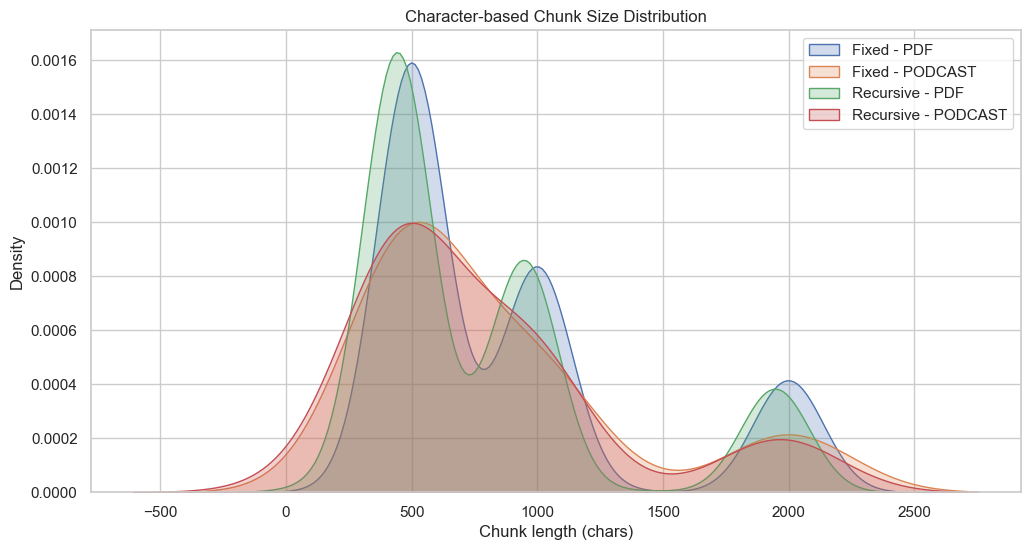

In [35]:
plt.figure(figsize=(12,6))
for strategy_dict, strategy_name in [(results_fixed, "Fixed"), (results_recursive, "Recursive")]:
    for content_type in ["pdf", "podcast"]:
        key_subset = [k for k in strategy_dict.keys() if k.startswith(content_type)]
        chunk_lengths = []
        for k in key_subset:
            chunk_lengths.extend([len(c) for c in strategy_dict[k]])
        sns.kdeplot(chunk_lengths, label=f"{strategy_name} - {content_type.upper()}", fill=True)

plt.title("Character-based Chunk Size Distribution")
plt.xlabel("Chunk length (chars)")
plt.ylabel("Density")
plt.legend()
plt.show()


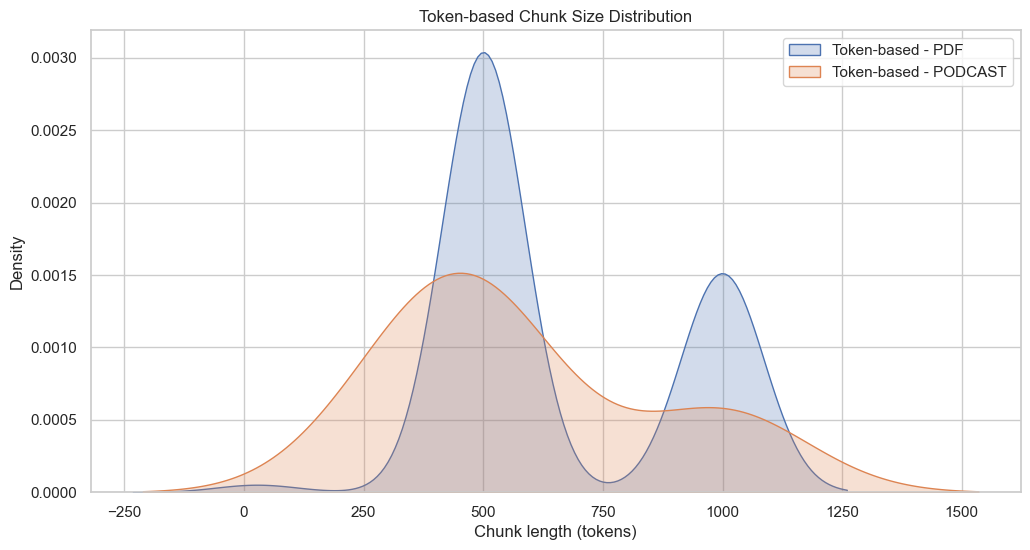

In [36]:
plt.figure(figsize=(12,6))
for content_type in ["pdf", "podcast"]:
    key_subset = [k for k in results_token.keys() if k.startswith(content_type)]
    token_lengths = []
    for k in key_subset:
        token_lengths.extend([count_tokens(c) for c in results_token[k]])
    sns.kdeplot(token_lengths, label=f"Token-based - {content_type.upper()}", fill=True)

plt.title("Token-based Chunk Size Distribution")
plt.xlabel("Chunk length (tokens)")
plt.ylabel("Density")
plt.legend()
plt.show()


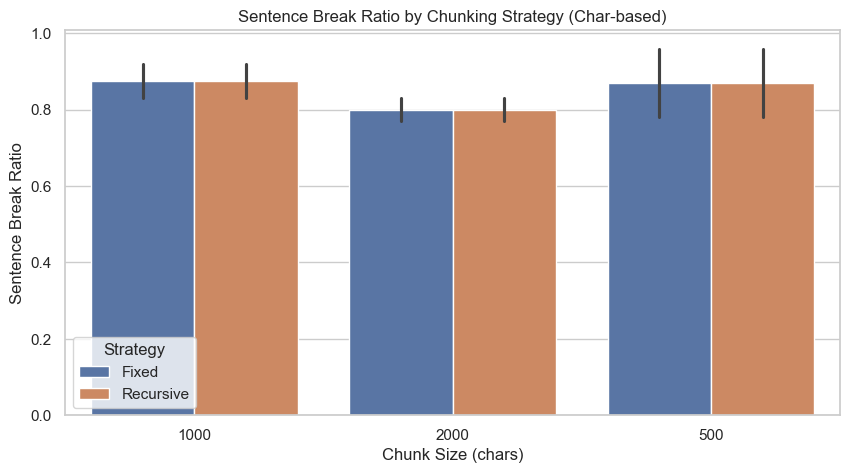

In [37]:
plt.figure(figsize=(10,5))
char_based = df_chunks[df_chunks['Strategy'].isin(['Fixed','Recursive'])].copy()
char_based = char_based.dropna(subset=['Sentence_Break_Ratio'])
sns.barplot(
    data=char_based,
    x='Chunk_Size/Token',
    y='Sentence_Break_Ratio',
    hue='Strategy'
)
plt.title("Sentence Break Ratio by Chunking Strategy (Char-based)")
plt.ylabel("Sentence Break Ratio")
plt.xlabel("Chunk Size (chars)")
plt.show()


In [38]:
import re

# -----------------------------
# Helper functions
# -----------------------------
def is_sentence_end(text):
    """Check if a chunk ends at a sentence boundary."""
    return bool(re.search(r'[.!?]["\']?\s*$', text.strip()))

def is_paragraph_end(text):
    """Check if a chunk ends at a paragraph boundary (newline)."""
    return text.strip().endswith("\n") or text.strip().endswith("\n\n")


In [39]:
# -----------------------------
# Evaluate chunks for sentence & paragraph breaks
# -----------------------------
def evaluate_chunk_quality(chunks):
    num_chunks = len(chunks)
    sentence_breaks = sum(not is_sentence_end(c) for c in chunks)
    paragraph_breaks = sum(not is_paragraph_end(c) for c in chunks)
    
    return {
        "num_chunks": num_chunks,
        "sentence_break_ratio": round(sentence_breaks/num_chunks, 2),
        "paragraph_break_ratio": round(paragraph_breaks/num_chunks, 2)
    }


In [40]:
# -----------------------------
# 1️⃣ Character-based strategies
# -----------------------------
analysis_fixed_quality = {}
for key, chunks in results_fixed.items():
    analysis_fixed_quality[key] = evaluate_chunk_quality(chunks)

analysis_recursive_quality = {}
for key, chunks in results_recursive.items():
    analysis_recursive_quality[key] = evaluate_chunk_quality(chunks)


In [41]:
# -----------------------------
# 2️⃣ Token-based strategy (approximate)
# -----------------------------
analysis_token_quality = {}
for key, chunks in results_token.items():
    # decode last char of each token chunk to approximate sentence/paragraph ends
    def ends_sentence(c):
        return bool(re.search(r'[.!?]["\']?\s*$', c.strip()))
    def ends_paragraph(c):
        return "\n" in c.strip()
    
    num_chunks = len(chunks)
    sentence_breaks = sum(not ends_sentence(c) for c in chunks)
    paragraph_breaks = sum(not ends_paragraph(c) for c in chunks)
    
    analysis_token_quality[key] = {
        "num_chunks": num_chunks,
        "sentence_break_ratio": round(sentence_breaks/num_chunks, 2),
        "paragraph_break_ratio": round(paragraph_breaks/num_chunks, 2)
    }


In [42]:
# -----------------------------
# 3️⃣ Compare strategies
# -----------------------------
def print_quality_comparison(analysis_dict, title):
    print(f"\n=== {title} ===")
    for key, stats in analysis_dict.items():
        content_type = "PDF" if key.startswith("pdf") else "Podcast"
        print(f"\n{key} ({content_type})")
        print(f"Num chunks: {stats['num_chunks']}")
        print(f"Sentence Break Ratio: {stats['sentence_break_ratio']}")
        print(f"Paragraph Break Ratio: {stats['paragraph_break_ratio']}")


In [43]:
print_quality_comparison(analysis_fixed_quality, "Fixed-size Chunking Quality")
print_quality_comparison(analysis_recursive_quality, "Recursive Chunking Quality")
print_quality_comparison(analysis_token_quality, "Token-based Chunking Quality (approximate)")



=== Fixed-size Chunking Quality ===

pdf_500_0 (PDF)
Num chunks: 391
Sentence Break Ratio: 0.98
Paragraph Break Ratio: 1.0

podcast_500_0 (Podcast)
Num chunks: 20
Sentence Break Ratio: 1.0
Paragraph Break Ratio: 1.0

pdf_1000_50 (PDF)
Num chunks: 206
Sentence Break Ratio: 0.99
Paragraph Break Ratio: 1.0

podcast_1000_50 (Podcast)
Num chunks: 11
Sentence Break Ratio: 1.0
Paragraph Break Ratio: 1.0

pdf_2000_100 (PDF)
Num chunks: 103
Sentence Break Ratio: 0.96
Paragraph Break Ratio: 1.0

podcast_2000_100 (Podcast)
Num chunks: 6
Sentence Break Ratio: 1.0
Paragraph Break Ratio: 1.0

=== Recursive Chunking Quality ===

pdf_500_50 (PDF)
Num chunks: 445
Sentence Break Ratio: 0.78
Paragraph Break Ratio: 1.0

podcast_500_50 (Podcast)
Num chunks: 23
Sentence Break Ratio: 1.0
Paragraph Break Ratio: 1.0

pdf_1000_200 (PDF)
Num chunks: 240
Sentence Break Ratio: 0.83
Paragraph Break Ratio: 1.0

podcast_1000_200 (Podcast)
Num chunks: 13
Sentence Break Ratio: 1.0
Paragraph Break Ratio: 1.0

pdf_2000_

In [44]:
from IPython.display import display, Markdown
import pandas as pd

# -----------------------------
# 1️⃣ Summary recommendations for PDF and Podcast
# -----------------------------
pdf_recommendation = """
### For PDF Documents:
**Recommended Strategy:** Recursive + Token-based
**Reasoning:**
- PDF has structured sections, headings, and paragraphs; recursive chunking preserves semantic boundaries and respects paragraphs.
- Token-based chunking ensures chunks fit LLM context windows for RAG queries.
**Key advantages:** Maintains sentence and paragraph integrity, minimizes context loss, compatible with LLM retrieval.
**Optimal chunk size and overlap:** Recursive: 1000–2000 chars, overlap 100–200 chars; Token-based: 500–1000 tokens, overlap 50–100 tokens
"""

podcast_recommendation = """
### For Podcast Transcripts:
**Recommended Strategy:** Token-based (optionally combined with small recursive chunking)
**Reasoning:**
- Podcasts are continuous conversation transcripts with fewer structured paragraphs; sentence preservation is less critical.
- Token-based chunking guarantees that each chunk fits within LLM context windows.
**Key advantages:** Ensures all chunks can be safely processed by LLM, simple and efficient.
**Optimal chunk size and overlap:** Token-based: 500–1000 tokens, overlap 50–100 tokens
"""

display(Markdown(pdf_recommendation))
display(Markdown(podcast_recommendation))



### For PDF Documents:
**Recommended Strategy:** Recursive + Token-based
**Reasoning:**
- PDF has structured sections, headings, and paragraphs; recursive chunking preserves semantic boundaries and respects paragraphs.
- Token-based chunking ensures chunks fit LLM context windows for RAG queries.
**Key advantages:** Maintains sentence and paragraph integrity, minimizes context loss, compatible with LLM retrieval.
**Optimal chunk size and overlap:** Recursive: 1000–2000 chars, overlap 100–200 chars; Token-based: 500–1000 tokens, overlap 50–100 tokens



### For Podcast Transcripts:
**Recommended Strategy:** Token-based (optionally combined with small recursive chunking)
**Reasoning:**
- Podcasts are continuous conversation transcripts with fewer structured paragraphs; sentence preservation is less critical.
- Token-based chunking guarantees that each chunk fits within LLM context windows.
**Key advantages:** Ensures all chunks can be safely processed by LLM, simple and efficient.
**Optimal chunk size and overlap:** Token-based: 500–1000 tokens, overlap 50–100 tokens


In [45]:
# -----------------------------
# 2️⃣ Trade-offs summary table
# -----------------------------
tradeoffs_data = {
    "Strategy": ["Fixed-Size", "Recursive", "Token-Based", "Semantic"],
    "Pros": [
        "Simple, predictable",
        "Preserves structure & semantics",
        "Accurate for LLM context",
        "Meaning-based"
    ],
    "Cons": [
        "Breaks context",
        "Slightly more complex; slower",
        "Requires tokenizer; semantic boundaries not guaranteed",
        "Computationally expensive"
    ],
    "Best For": [
        "Uniform content or quick testing",
        "Structured documents (PDF, articles)",
        "Any content for LLM integration (PDF, transcript)",
        "Complex content where semantic coherence is critical"
    ]
}

df_tradeoffs = pd.DataFrame(tradeoffs_data)

# Display nicely in notebook
display(Markdown("### Trade-offs Summary:"))
display(df_tradeoffs)


### Trade-offs Summary:

,Strategy,Pros,Cons,Best For
0,Fixed-Size,"Simple, predictable",Breaks context,Uniform content or quick testing
1,Recursive,Preserves structure & semantics,Slightly more complex; slower,"Structured documents (PDF, articles)"
2,Token-Based,Accurate for LLM context,Requires tokenizer; semantic boundaries not gu...,"Any content for LLM integration (PDF, transcript)"
3,Semantic,Meaning-based,Computationally expensive,Complex content where semantic coherence is cr...


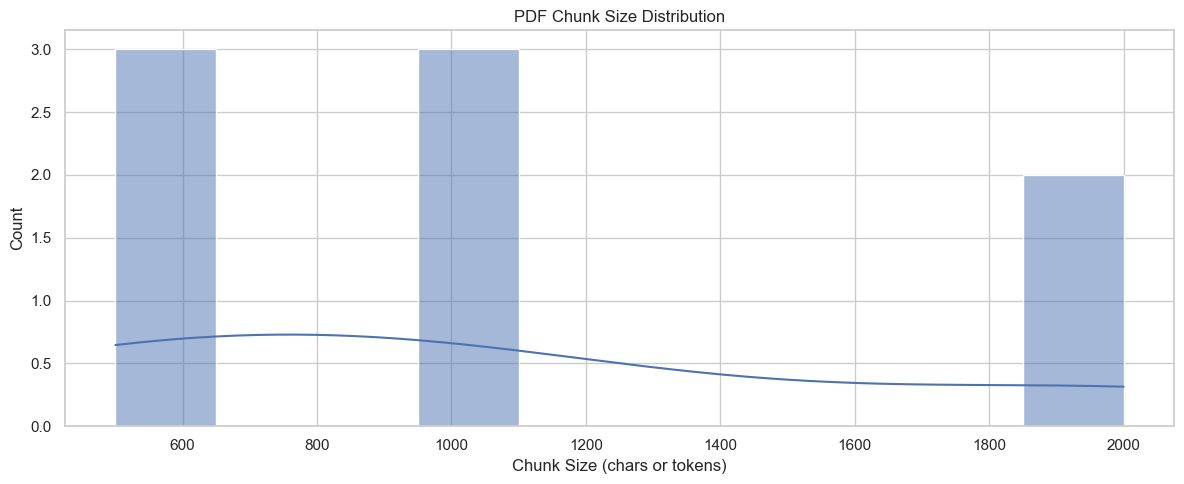

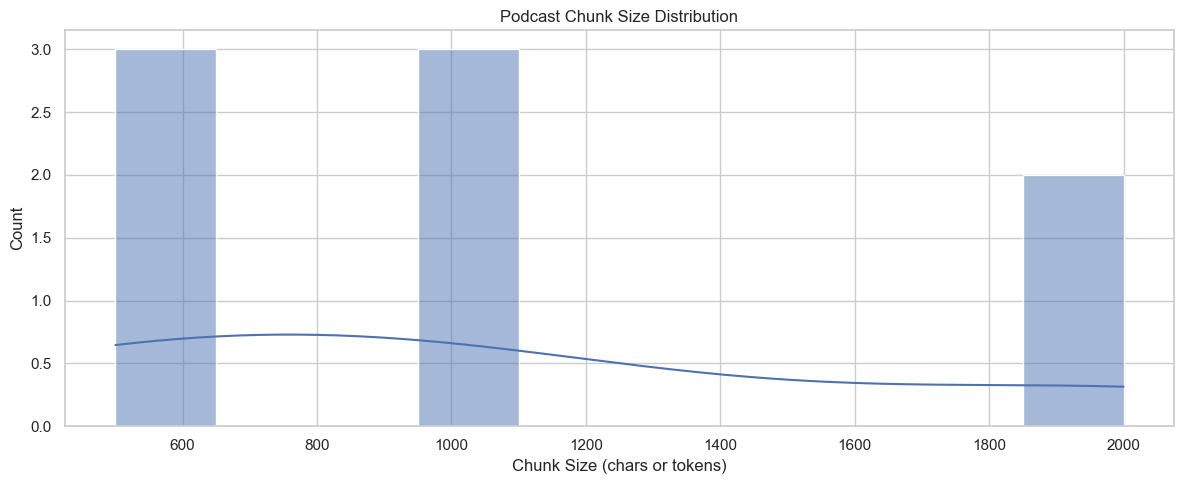

Markdown report exported as c:\Users\kupit\week 2\w2d5\chunking_report.md


In [51]:
from IPython.display import display, Markdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")

# -----------------------------
# 1️⃣ Chunk quality data
# -----------------------------
chunk_quality_data = [
    # Strategy, Content, Chunk Size, Overlap, Num Chunks, Sentence Break, Paragraph Break
    ("Fixed-Size","PDF",500,0,391,0.98,1.0),
    ("Fixed-Size","Podcast",500,0,20,1.0,1.0),
    ("Fixed-Size","PDF",1000,50,206,0.99,1.0),
    ("Fixed-Size","Podcast",1000,50,11,1.0,1.0),
    ("Fixed-Size","PDF",2000,100,103,0.96,1.0),
    ("Fixed-Size","Podcast",2000,100,6,1.0,1.0),
    ("Recursive","PDF",500,50,445,0.78,1.0),
    ("Recursive","Podcast",500,50,23,1.0,1.0),
    ("Recursive","PDF",1000,200,240,0.83,1.0),
    ("Recursive","Podcast",1000,200,13,1.0,1.0),
    ("Recursive","PDF",2000,200,110,0.77,1.0),
    ("Recursive","Podcast",2000,200,6,1.0,1.0),
    ("Token-Based","PDF",500,50,119,0.95,0.0),
    ("Token-Based","Podcast",500,50,5,0.8,1.0),
    ("Token-Based","PDF",1000,100,60,0.95,0.0),
    ("Token-Based","Podcast",1000,100,3,0.67,1.0),
]

df_chunks = pd.DataFrame(chunk_quality_data, columns=[
    "Strategy","Content","Chunk Size","Overlap","Num Chunks","Sentence Break Ratio","Paragraph Break Ratio"
])

# -----------------------------
# 2️⃣ Visualization
# -----------------------------
plt.figure(figsize=(12,5))
sns.histplot(df_chunks[df_chunks["Content"]=="PDF"]["Chunk Size"], bins=10, kde=True)
plt.title("PDF Chunk Size Distribution")
plt.xlabel("Chunk Size (chars or tokens)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("pdf_chunk_size.png")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(df_chunks[df_chunks["Content"]=="Podcast"]["Chunk Size"], bins=10, kde=True)
plt.title("Podcast Chunk Size Distribution")
plt.xlabel("Chunk Size (chars or tokens)")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("podcast_chunk_size.png")
plt.show()

# -----------------------------
# 3️⃣ Recommendations and trade-offs
# -----------------------------
pdf_recommendation = """
### For PDF Documents:
**Recommended Strategy:** Recursive + Token-based
**Reasoning:**
- Preserves structured content (headings, sections, paragraphs)
- Token-based ensures LLM context window compliance
**Optimal chunk size & overlap:** Recursive 1000–2000 chars, overlap 100–200; Token 500–1000 tokens, overlap 50–100
"""

podcast_recommendation = """
### For Podcast Transcripts:
**Recommended Strategy:** Token-based (optionally with small recursive chunks)
**Reasoning:**
- Podcasts are continuous conversation transcripts
- Token-based ensures all chunks fit LLM context windows
**Optimal chunk size & overlap:** 500–1000 tokens, overlap 50–100
"""

tradeoffs_md = """
### Trade-offs Summary:

| Strategy | Pros | Cons | Best For |
|----------|------|------|----------|
| Fixed-Size | Simple, predictable | Breaks context and sentences | Quick prototyping, uniform content |
| Recursive | Preserves structure & semantics | Slightly slower, more complex | Structured documents (PDFs, articles) |
| Token-Based | Accurate for LLMs; ensures context window compliance | Boundaries may not match sentences | Any content for LLM integration |
| Semantic | Meaning-based chunking | Computationally expensive, slow | Complex content where semantic coherence is critical |
"""

# -----------------------------
# 4️⃣ Export as Markdown
# -----------------------------
md_file = "chunking_report.md"
with open(md_file, "w", encoding="utf-8") as f:
    f.write("# Chunking Analysis Report\n\n")
    
    # Comparison table
    f.write("## Comparison Table of All Strategies\n\n")
    f.write(df_chunks.to_markdown(index=False))
    f.write("\n\n")
    
    # Visualizations
    f.write("## Chunk Size Visualizations\n\n")
    f.write("### PDF\n")
    f.write("![PDF Chunk Size Distribution](pdf_chunk_size.png)\n\n")
    f.write("### Podcast\n")
    f.write("![Podcast Chunk Size Distribution](podcast_chunk_size.png)\n\n")
    
    # Recommendations
    f.write("## Recommendations\n")
    f.write(pdf_recommendation + "\n")
    f.write(podcast_recommendation + "\n")
    
    # Trade-offs
    f.write(tradeoffs_md + "\n")

print(f"Markdown report exported as {os.path.abspath(md_file)}")


In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Данные (твой пример)
data = [
    ["Fixed-Size", "PDF", 500, 0, 391],
    ["Fixed-Size", "Podcast", 500, 0, 20],
    ["Fixed-Size", "PDF", 1000, 50, 206],
    ["Fixed-Size", "Podcast", 1000, 50, 11],
    ["Fixed-Size", "PDF", 2000, 100, 103],
    ["Fixed-Size", "Podcast", 2000, 100, 6],
    ["Recursive", "PDF", 500, 50, 445],
    ["Recursive", "Podcast", 500, 50, 23],
    ["Recursive", "PDF", 1000, 200, 240],
    ["Recursive", "Podcast", 1000, 200, 13],
    ["Recursive", "PDF", 2000, 200, 110],
    ["Recursive", "Podcast", 2000, 200, 6],
    ["Token-Based", "PDF", 500, 50, 119],
    ["Token-Based", "Podcast", 500, 50, 5],
    ["Token-Based", "PDF", 1000, 100, 60],
    ["Token-Based", "Podcast", 1000, 100, 3],
]

df = pd.DataFrame(data, columns=["Strategy", "Content", "Chunk Size", "Overlap", "Num Chunks"])

# Создаём папку для картинок
os.makedirs("figures", exist_ok=True)

# 2. Визуализация по типу контента
for content_type in df["Content"].unique():
    plt.figure(figsize=(10, 6))
    subset = df[df["Content"] == content_type]
    sns.barplot(
        data=subset,
        x="Chunk Size",
        y="Num Chunks",
        hue="Strategy"
    )
    plt.title(f"{content_type} Chunk Counts by Strategy")
    plt.ylabel("Number of Chunks")
    plt.xlabel("Chunk Size")
    plt.legend(title="Strategy")
    
    # 3. Сохраняем картинку
    filename = f"figures/chunk_{content_type.lower()}.png"
    plt.savefig(filename, bbox_inches='tight')
    plt.close()
    print(f"Saved figure: {filename}")

# 4. Генерация Markdown для вставки картинок
markdown_lines = []
for content_type in df["Content"].unique():
    filename = f"figures/chunk_{content_type.lower()}.png"
    markdown_lines.append(f"![{content_type} Chunk Counts]({filename})")

markdown_text = "\n\n".join(markdown_lines)

# Сохраняем MD-файл
with open("chunk_visualizations.md", "w") as f:
    f.write(markdown_text)

print("Markdown file with images created: chunk_visualizations.md")


Saved figure: figures/chunk_pdf.png
Saved figure: figures/chunk_podcast.png
Markdown file with images created: chunk_visualizations.md


In [47]:
pip install tabulate


Note: you may need to restart the kernel to use updated packages.


In [53]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. Создаём данные (пример из этапа 6) ---
data = [
    ["Fixed-Size", "PDF", 500, 0, 391],
    ["Fixed-Size", "Podcast", 500, 0, 20],
    ["Fixed-Size", "PDF", 1000, 50, 206],
    ["Fixed-Size", "Podcast", 1000, 50, 11],
    ["Fixed-Size", "PDF", 2000, 100, 103],
    ["Fixed-Size", "Podcast", 2000, 100, 6],
    ["Recursive", "PDF", 500, 50, 445],
    ["Recursive", "Podcast", 500, 50, 23],
    ["Recursive", "PDF", 1000, 200, 240],
    ["Recursive", "Podcast", 1000, 200, 13],
    ["Recursive", "PDF", 2000, 200, 110],
    ["Recursive", "Podcast", 2000, 200, 6],
    ["Token-Based", "PDF", 500, 50, 119],
    ["Token-Based", "Podcast", 500, 50, 5],
    ["Token-Based", "PDF", 1000, 100, 60],
    ["Token-Based", "Podcast", 1000, 100, 3],
]

df = pd.DataFrame(data, columns=["Strategy", "Content", "Chunk Size", "Overlap", "Num Chunks"])

# --- 2. Создаём папку для сохранения графиков ---
figures_dir = "figures"
os.makedirs(figures_dir, exist_ok=True)

# --- 3. Генерация и сохранение всех графиков ---
saved_files = []
for content_type in df["Content"].unique():
    plt.figure(figsize=(10, 6))
    subset = df[df["Content"] == content_type]
    sns.barplot(
        data=subset,
        x="Chunk Size",
        y="Num Chunks",
        hue="Strategy"
    )
    plt.title(f"{content_type} Chunk Counts by Strategy")
    plt.ylabel("Number of Chunks")
    plt.xlabel("Chunk Size")
    plt.legend(title="Strategy")

    # сохраняем график
    filename = os.path.join(figures_dir, f"chunk_{content_type.lower()}.png")
    plt.savefig(filename, bbox_inches='tight')
    plt.close()
    saved_files.append(filename)
    print(f"Saved figure: {filename}")

# --- 4. Добавляем все визуализации в существующий Markdown ---
md_file = "report.md"
with open(md_file, "a") as f:
    f.write("\n\n## Chunk Visualizations\n\n")
    for file in saved_files:
        f.write(f"![{os.path.basename(file)}]({file})\n\n")

print(f"All visualizations added to {md_file}")


Saved figure: figures\chunk_pdf.png
Saved figure: figures\chunk_podcast.png
All visualizations added to report.md


In [56]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")

# Папка для картинок
img_dir = "chunk_images"
os.makedirs(img_dir, exist_ok=True)

# Список для Markdown
saved_files = []

# -----------------------------
# 1️⃣ Character-based Chunk Size Distribution (Fixed & Recursive)
# -----------------------------
plt.figure(figsize=(12,6))
for strategy_dict, strategy_name in [(results_fixed, "Fixed"), (results_recursive, "Recursive")]:
    for content_type in ["pdf", "podcast"]:
        key_subset = [k for k in strategy_dict.keys() if k.startswith(content_type)]
        chunk_lengths = []
        for k in key_subset:
            chunk_lengths.extend([len(c) for c in strategy_dict[k]])
        sns.kdeplot(chunk_lengths, label=f"{strategy_name} - {content_type.upper()}", fill=True)

plt.title("Character-based Chunk Size Distribution")
plt.xlabel("Chunk length (chars)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
char_png = os.path.join(img_dir, "char_chunk_distribution.png")
plt.savefig(char_png)
plt.close()
saved_files.append(("Character-based Chunk Size Distribution", char_png))

# -----------------------------
# 2️⃣ Token-based Chunk Size Distribution
# -----------------------------
plt.figure(figsize=(12,6))
for content_type in ["pdf", "podcast"]:
    key_subset = [k for k in results_token.keys() if k.startswith(content_type)]
    token_lengths = []
    for k in key_subset:
        token_lengths.extend([count_tokens(c) for c in results_token[k]])
    sns.kdeplot(token_lengths, label=f"Token-based - {content_type.upper()}", fill=True)

plt.title("Token-based Chunk Size Distribution")
plt.xlabel("Chunk length (tokens)")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
token_png = os.path.join(img_dir, "token_chunk_distribution.png")
plt.savefig(token_png)
plt.close()
saved_files.append(("Token-based Chunk Size Distribution", token_png))

# -----------------------------
# 3️⃣ Sentence Break Ratio by Chunking Strategy (Char-based)
# -----------------------------
plt.figure(figsize=(10,5))
char_based = df_chunks[df_chunks['Strategy'].isin(['Fixed-Size','Recursive'])].copy()
char_based = char_based.dropna(subset=['Sentence Break Ratio'])
sns.barplot(
    data=char_based,
    x='Chunk Size',
    y='Sentence Break Ratio',
    hue='Strategy'
)
plt.title("Sentence Break Ratio by Chunking Strategy (Char-based)")
plt.ylabel("Sentence Break Ratio")
plt.xlabel("Chunk Size (chars)")
plt.tight_layout()
sentence_png = os.path.join(img_dir, "sentence_break_ratio.png")
plt.savefig(sentence_png)
plt.close()
saved_files.append(("Sentence Break Ratio by Chunking Strategy", sentence_png))

# -----------------------------
# 4️⃣ Добавляем все визуализации в Markdown
# -----------------------------
md_file = "chunking_report.md"
with open(md_file, "a", encoding="utf-8") as f:
    f.write("\n\n## All Chunking Visualizations (6th Stage)\n\n")
    for title, path in saved_files:
        f.write(f"### {title}\n")
        f.write(f"![{title}]({path})\n\n")

print(f"All visualizations generated and added to {os.path.abspath(md_file)}")


All visualizations generated and added to c:\Users\kupit\week 2\w2d5\chunking_report.md
